In [ ]:
# ライブラリのインストール
# (Jupyterで実行する場合は先頭に `!` または `%pip` を付けます)
%pip install matplotlib scikit-learn
%pip install japanize-matplotlib
# ↑ galrパッケージは現在PyPIに公開されていないため、ローカル開発環境にインストールしてください
# 例: クローン後、`pip install -e .` を実行

# Gated Asymmetric Linear Regression (GALR) チュートリアル

このノートブックでは、GALRパッケージの基本的な使用方法を説明します。

GALRは、特徴量に応じて上振れ（過大予測）と下振れ（過小予測）のペナルティを学習する回帰モデルです。


## 1. パッケージのインポート


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import japanize_matplotlib

from galr import GALRRegressor

## 2. データの生成

デモンストレーション用に、非対称なコスト構造を持つデータを生成します。


In [18]:
# データ生成
n_samples = 500
n_features = 3

# 特徴量
X = np.random.randn(n_samples, n_features)

# 真の回帰係数
true_beta = np.array([2.0, -1.5, 0.8])
true_intercept = 1.0

# ターゲット値（線形関係 + ノイズ）
y = X @ true_beta + true_intercept + np.random.randn(n_samples) * 0.5

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"訓練データ数: {X_train.shape[0]}")
print(f"テストデータ数: {X_test.shape[0]}")
print(f"特徴量数: {X_train.shape[1]}")


訓練データ数: 400
テストデータ数: 100
特徴量数: 3


## 3. GALRモデルの学習


In [19]:
# GALRモデルのインスタンス作成
galr = GALRRegressor(
    gate='linear',
    fit_intercept=True,
    optimizer='sgd',
    lr=0.01,
    n_iter=2000,
    tol=1e-6,
    lambda_beta=0.01,
    lambda_gate=0.01,
    epsilon=1e-6,
    standardize=True,
    random_state=42
)

# 学習
galr.fit(X_train, y_train)

print(f"学習完了（イテレーション数: {galr.n_iter_})")
print(f"最終損失: {galr.loss_history_[-1]:.6f}")


学習完了（イテレーション数: 1225)
最終損失: 0.203829


## 4. 学習曲線の可視化


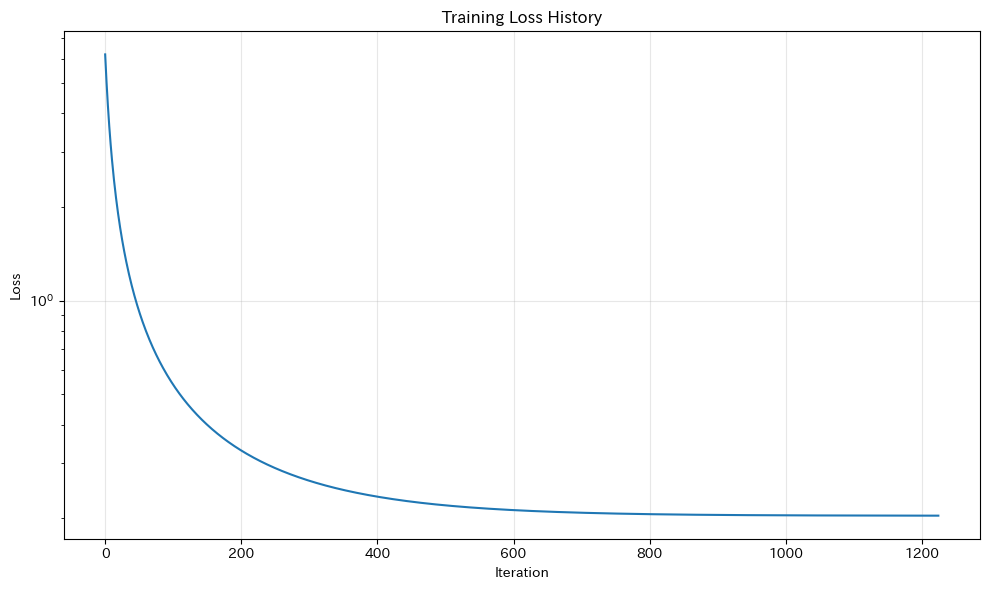

In [20]:
# 学習曲線のプロット
plt.figure(figsize=(10, 6))
plt.plot(galr.loss_history_)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()


## 5. 予測と評価


In [21]:
# 予測
y_pred_train = galr.predict(X_train)
y_pred_test = galr.predict(X_test)

# 評価指標
print("=== 訓練データ ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.4f}")

print("\n=== テストデータ ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")


=== 訓練データ ===
RMSE: 0.9516
MAE: 0.7513

=== テストデータ ===
RMSE: 0.8981
MAE: 0.7562


## 6. 予測結果の可視化


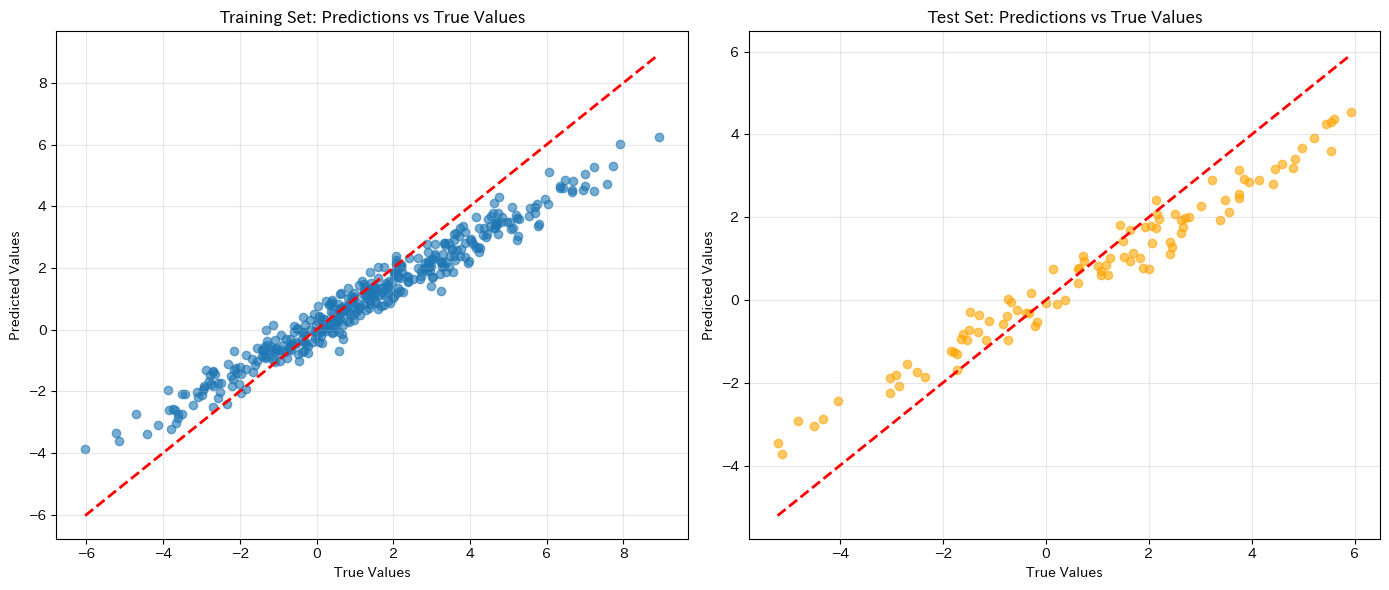

In [22]:
# 予測 vs 実測値のプロット
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 訓練データ
axes[0].scatter(y_train, y_pred_train, alpha=0.6)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('True Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Training Set: Predictions vs True Values')
axes[0].grid(True, alpha=0.3)

# テストデータ
axes[1].scatter(y_test, y_pred_test, alpha=0.6, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Test Set: Predictions vs True Values')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. ゲート関数と重みの確認

GALRの特徴である、特徴量に応じた重みを確認します。


In [23]:
# ゲート関数の値を取得
gate_values_train = galr.get_gate_values(X_train)
gate_values_test = galr.get_gate_values(X_test)

# 重みを取得
w_under_train, w_over_train = galr.get_weights(X_train)
w_under_test, w_over_test = galr.get_weights(X_test)

print("=== ゲート関数の統計 ===")
print(f"訓練データ - ゲート値の平均: {gate_values_train.mean():.4f}")
print(f"訓練データ - ゲート値の標準偏差: {gate_values_train.std():.4f}")
print(f"\n訓練データ - 下振れ重みの平均: {w_under_train.mean():.4f}")
print(f"訓練データ - 上振れ重みの平均: {w_over_train.mean():.4f}")
print(f"\nテストデータ - 下振れ重みの平均: {w_under_test.mean():.4f}")
print(f"テストデータ - 上振れ重みの平均: {w_over_test.mean():.4f}")


=== ゲート関数の統計 ===
訓練データ - ゲート値の平均: -0.9241
訓練データ - ゲート値の標準偏差: 2.0223

訓練データ - 下振れ重みの平均: 0.6786
訓練データ - 上振れ重みの平均: 1.6027

テストデータ - 下振れ重みの平均: 0.7802
テストデータ - 上振れ重みの平均: 1.4657


## 8. 重みの分布の可視化


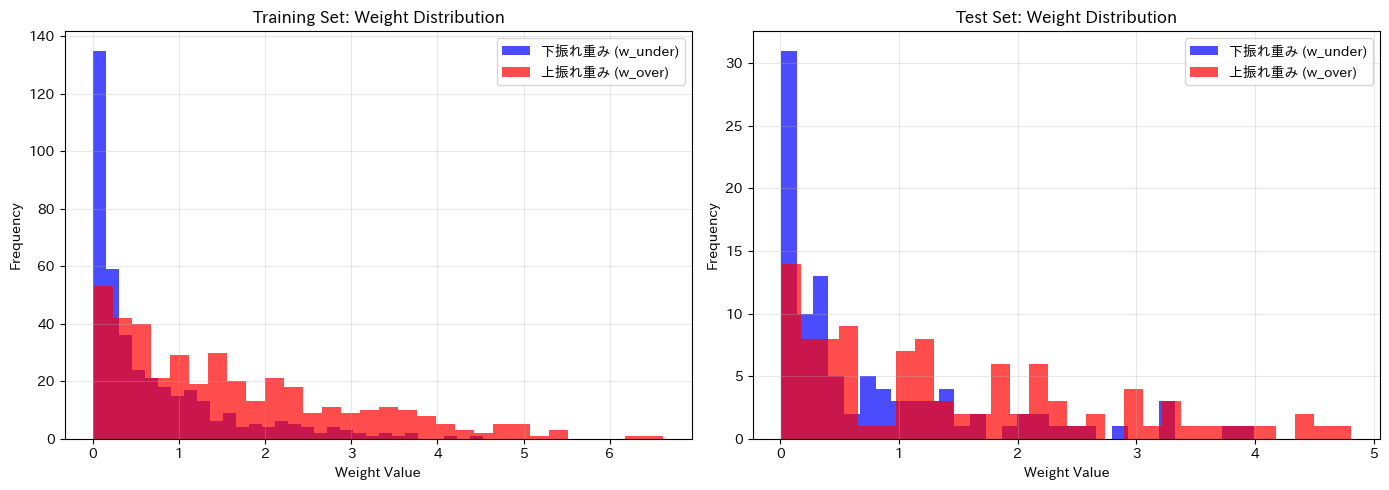

In [24]:
# 重みの分布を可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 訓練データの重み分布
axes[0].hist(w_under_train, bins=30, alpha=0.7, label='下振れ重み (w_under)', color='blue')
axes[0].hist(w_over_train, bins=30, alpha=0.7, label='上振れ重み (w_over)', color='red')
axes[0].set_xlabel('Weight Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Training Set: Weight Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# テストデータの重み分布
axes[1].hist(w_under_test, bins=30, alpha=0.7, label='下振れ重み (w_under)', color='blue')
axes[1].hist(w_over_test, bins=30, alpha=0.7, label='上振れ重み (w_over)', color='red')
axes[1].set_xlabel('Weight Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Test Set: Weight Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 9. ゲート値と残差の関係

ゲート値が大きいほど下振れのペナルティが大きくなることを確認します。


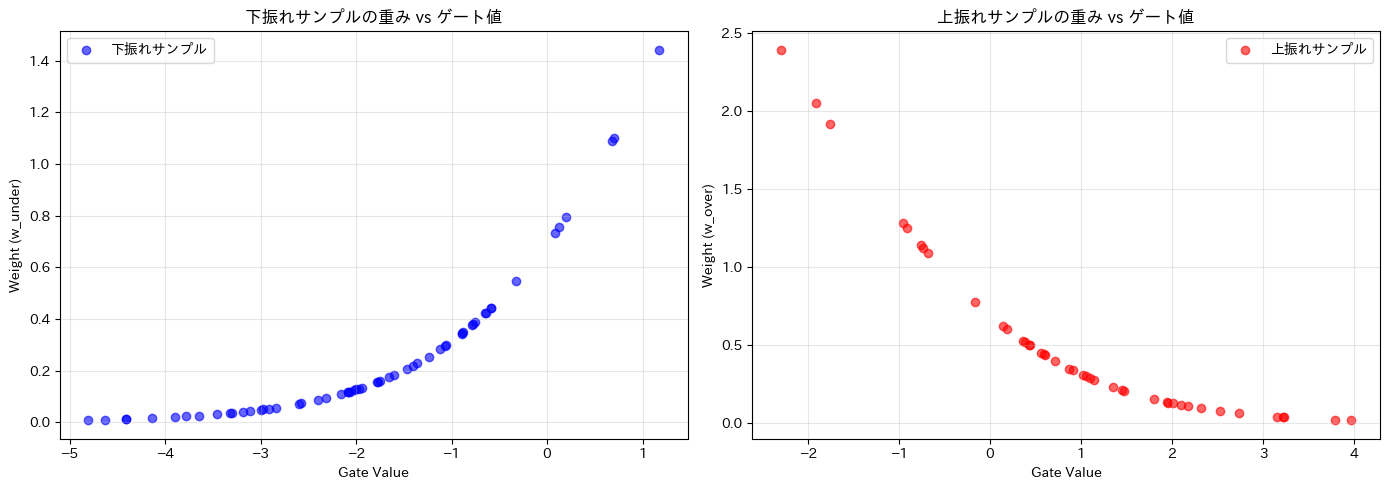

In [25]:
# 残差を計算
residuals_test = y_test - y_pred_test

# ゲート値と残差の関係を可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 下振れ（過小予測）の場合
mask_under = residuals_test > 0
axes[0].scatter(gate_values_test[mask_under], w_under_test[mask_under], 
                alpha=0.6, label='下振れサンプル', color='blue')
axes[0].set_xlabel('Gate Value')
axes[0].set_ylabel('Weight (w_under)')
axes[0].set_title('下振れサンプルの重み vs ゲート値')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 上振れ（過大予測）の場合
mask_over = residuals_test < 0
axes[1].scatter(gate_values_test[mask_over], w_over_test[mask_over], 
                alpha=0.6, label='上振れサンプル', color='red')
axes[1].set_xlabel('Gate Value')
axes[1].set_ylabel('Weight (w_over)')
axes[1].set_title('上振れサンプルの重み vs ゲート値')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. 従来の線形回帰との比較


In [26]:
# 従来の線形回帰モデル
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr_test = lr.predict(X_test)

# 評価比較
print("=== モデル比較（テストデータ）===")
print(f"\n線形回帰:")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr_test)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_lr_test):.4f}")

print(f"\nGALR:")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")


=== モデル比較（テストデータ）===

線形回帰:
  RMSE: 0.4629
  MAE: 0.3777

GALR:
  RMSE: 0.8981
  MAE: 0.7562


## 11. 残差の分布比較


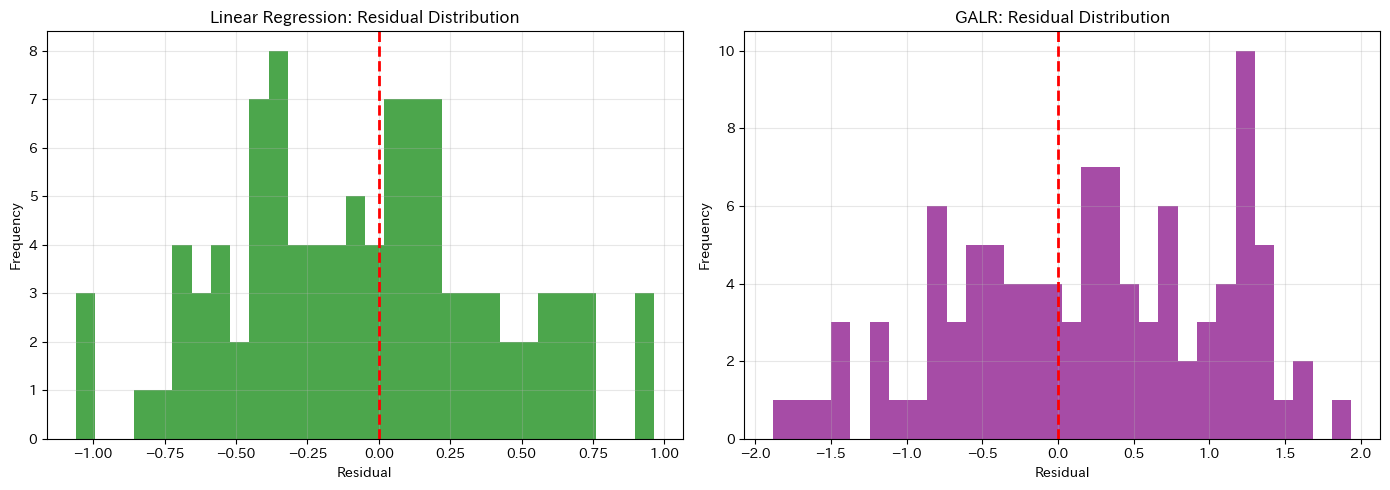

In [27]:
# 残差の分布を比較
residuals_lr_test = y_test - y_pred_lr_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 線形回帰の残差
axes[0].hist(residuals_lr_test, bins=30, alpha=0.7, color='green')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Linear Regression: Residual Distribution')
axes[0].grid(True, alpha=0.3)

# GALRの残差
axes[1].hist(residuals_test, bins=30, alpha=0.7, color='purple')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].set_title('GALR: Residual Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 12. 学習されたパラメータの確認


In [28]:
print("=== 学習されたパラメータ ===")
print(f"\n回帰係数 (beta):")
print(galr.beta_)
print(f"\n切片 (intercept): {galr.intercept_:.4f}")
print(f"\nゲートパラメータ (theta):")
print(galr.theta_)
print(f"\nゲート切片 (gate_intercept): {galr.gate_intercept_:.4f}")

print(f"\n\n=== 真のパラメータ（比較用）===")
print(f"真の回帰係数: {true_beta}")
print(f"真の切片: {true_intercept}")


=== 学習されたパラメータ ===

回帰係数 (beta):
[ 1.41957515 -1.07732597  0.57427446]

切片 (intercept): 0.9837

ゲートパラメータ (theta):
[-1.46601974  1.18942156 -0.6505493 ]

ゲート切片 (gate_intercept): -0.9241


=== 真のパラメータ（比較用）===
真の回帰係数: [ 2.  -1.5  0.8]
真の切片: 1.0


## まとめ

このチュートリアルでは、GALRパッケージの基本的な使用方法を説明しました。

主なポイント:
- GALRは特徴量に応じて上振れ/下振れのペナルティを学習する
- ゲート関数により、状況に応じたコスト比が自動的に決定される
- `get_gate_values()`や`get_weights()`メソッドで、学習された重みを確認できる

実際の応用では、ビジネス要件に応じて適切な正則化パラメータ（`lambda_beta`, `lambda_gate`）や学習率（`lr`）を調整してください。
